In [2]:
import pandas as pd
import datetime as dt
from IPython.display import display
from sklearn.impute import SimpleImputer
import os
import tensorflow as tf

# tf.config.experimental.set_memory_growth(gpus[0], True)

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')

class DataPreprocessor:
    def __init__(self, filename):
        self.filename = filename
        self.df = pd.read_csv(self.filename)
    
    def drop_duplicates(self):
        remove_duplicates = input("Do you want to remove duplicates? Input T or F ") == "T"
        if remove_duplicates:
            self.df.drop_duplicates(inplace=True)
    
    def impute_missing(self, method='mean'):
        impute_values = input("Do you want to impute values? Input T or F ") == "T"
        if impute_values:
            impute_strategy = input("How do you want to impute your values? e.g. \"median\", \"0\" " )
            imputer = SimpleImputer()
            if impute_strategy.isdigit():
                imputer = SimpleImputer(strategy='constant', fill_value=int(impute_strategy))
            else:
                imputer = SimpleImputer(strategy = impute_strategy)
            self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.df.columns)
            
    def display_table(self):
        display(self.df)
        to_csv = input("This is your new data file -- do you want to download it? Input T or F ") == "T"
        if to_csv:
            # Get the current timestamp
            timestamp = dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

            # Define the output filename
            # Split the filename into basename and extension
            basename, extension = os.path.splitext(self.filename)
            download_filename = f'{basename}_{timestamp}{extension}'

            # Download the dataframe to the output file
            self.df.to_csv(download_filename, index=False)
            
    def return_data(self):
        return self.df.iloc[:, :-1].values
        
    def return_labels(self):
        return self.df.iloc[:, -1].values


In [3]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, recall_score, precision_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

class Clustering:
    def __init__(self, data):
        self.model = None
        self.data = data
        self.pc_to_plot = 2
        
        #used to calculate different scores, if needed
        self.labels = None
    
    def f1_score(self, labels_true):
        return f1_score(labels_true, self.labels)
    
    def recall_score(self, labels_true):
        return recall_score(labels_true, self.labels)
    
    def precision_score(self, labels_true):
        return precision_score(labels_true, self.labels)
    
    def silhouette_score(self, data):
        return silhouette_score(data, self.labels)
    
    def cluster(self):
        raise NotImplementedError()
    
    def plot_clusters(self, model):
        # Fit PCA to the data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.data)
        
        # Get the cluster labels and the number of clusters
        labels = self.labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Plot the data points colored by cluster
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
        plt.title(f'Clustering on PCA (Number of Clusters: {n_clusters})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Remove values on the x and y axes
        plt.tick_params(labelbottom=False, labelleft=False)
        
        #Show the plot
        plt.show()

class KMeansClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def elbow_method(self):
        # Calculate the within-cluster sum of squares (WCSS) for each k value
        wcss = []
        
        # Define range of k values to test
        k_values = range(1, 10)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(self.data)
            wcss.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, wcss, 'bx-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        # Determine the optimal number of clusters
        diffs = np.diff(wcss)
        diff_ratios = diffs[1:] / diffs[:-1]
        optimal_k = k_values[np.argmin(diff_ratios) + 1]

        # Display the optimal number of clusters
        plt.axvline(x=optimal_k, linestyle='--', color='r', label=f'Optimal k={optimal_k}')
        plt.legend()
        plt.show()

        print(f"Optimal number of clusters: {optimal_k}")
        
        return optimal_k
    
    def cluster(self, n_clusters=None):
        warnings.filterwarnings("ignore")
        if n_clusters is None:
            n_clusters = self.elbow_method()
        kmeans = KMeans(n_clusters=n_clusters)
        self.model = kmeans
        self.labels = kmeans.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)

class DBSCANClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, eps=None, min_samples=None):
        warnings.filterwarnings("ignore")
        if eps is None:
#             eps = np.sqrt(self.data.shape[1])
            eps=5000
        if min_samples is None:
            min_samples = 2 * self.data.shape[1]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.model = dbscan
        self.labels = dbscan.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import AgglomerativeClustering

class AgglomerativeClusteringAlgorithm(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    # The linkage parameter specifies the method used to compute the distance between clusters. 
    # It determines the way clusters are merged during the hierarchical clustering process.
    def cluster(self, n_clusters=2, linkage='ward'):
        self.model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        self.labels = model.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import MeanShift

class MeanShiftClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self):
        self.model = MeanShift()
        self.labels = self.model.fit_predict(self.data)
        self.centers = self.model.cluster_centers_
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.ensemble import IsolationForest

class IsolationForestClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)

    def cluster(self, contamination=None):
        if contamination is None:
            contamination = 0.05
        self.model = IsolationForest(contamination=contamination)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.mixture import BayesianGaussianMixture

class BGMMClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, n_components=None):
        if n_components is None:
            n_components = 2
        self.model = BayesianGaussianMixture(n_components=n_components)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2D, MaxPooling2D, UpSampling2D, Cropping1D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

class DLModel:
    def __init__(self):
        self.model = None
        self.history = None
    
    def train(self):
        pass
    
    def detect(self, new_data):
        pass
    
    def define_model(self):
        pass
    
    def save_model(self):
        
        # Get the current time as a string
        timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')

        # Construct the filename with the timestamp
        filename = f'my_model_{timestamp}.h5'

        # Save the model to the file with the timestamped name
        self.model.save(filename)
        
        # Print message indicating the model has been saved
        print(f'Model saved to {filename}')
        
class AnomalyDetectionModel(DLModel):
    def __init__(self):
        super().__init__()

class ConvolutionalAutoencoder(AnomalyDetectionModel):
    
    def __init__(self):
        super().__init__()
        self.define_model()
        
    def define_model(self):
        x = Input(shape=(28, 28,1)) 

        # Encoder
        conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
        conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
        conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
        h = MaxPooling2D((2, 2), padding='same')(conv1_3)

        # Decoder
        conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
        up1 = UpSampling2D((2, 2))(conv2_1)
        conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
        up2 = UpSampling2D((2, 2))(conv2_2)
        conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
        up3 = UpSampling2D((2, 2))(conv2_3)
        r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

        autoencoder = Model(inputs=x, outputs=r)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.model = autoencoder
    
    def train_model(self, X_train, X_test, checkpoint_filepath='model_checkpoint.h5'):
        checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        # Train the model with checkpoints
        self.history = self.model.fit(X_train, X_train, batch_size=3,
                                      epochs=5, verbose=1, validation_data=(X_test, X_test))
        
        self.save_model()
        
    def plot_loss(self):
        if not self.history:
            print("Please train your model to get your model history")
            return
        print(self.history.history.keys())

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
    
    def plot_decoded_imgs(self, X_test):
        decoded_imgs = self.model.predict(X_test)
        n = 10
        plt.figure(figsize=(20, 6))
        for i in range(n):
            # display original
            ax = plt.subplot(3, n, i+1)
            plt.imshow(X_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            # display reconstruction
            ax = plt.subplot(3, n, i+n+1)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()
        
    def load_model(self, model_path):
        self.model = load_model(model_path)
        self.model.summary()

In [5]:
#Sample use case
from keras.datasets import mnist
from keras.utils import np_utils

nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)



X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Epoch 1/5
   15/20000 [..............................] - ETA: 1:12 - loss: 0.6859   

2023-04-12 18:22:50.779699: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f35e8040a90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-12 18:22:50.779735: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-04-12 18:22:50.788915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-12 18:22:50.847620: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 [==============================] - 61s 3ms/step - loss: 0.4920 - val_loss: 0.4434
Epoch 2/5
20000/20000 [==============================] - 62s 3ms/step - loss: 0.3957 - val_loss: 0.3416
Epoch 3/5
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2913 - val_loss: 0.2598
Epoch 4/5
20000/20000 [==============================] - 64s 3ms/step - loss: 0.2429 - val_loss: 0.2321
Epoch 5/5
20000/20000 [==============================] - 66s 3ms/step - loss: 0.2254 - val_loss: 0.2208
Model saved to my_model_20230412_182806.h5
dict_keys(['loss', 'val_loss'])


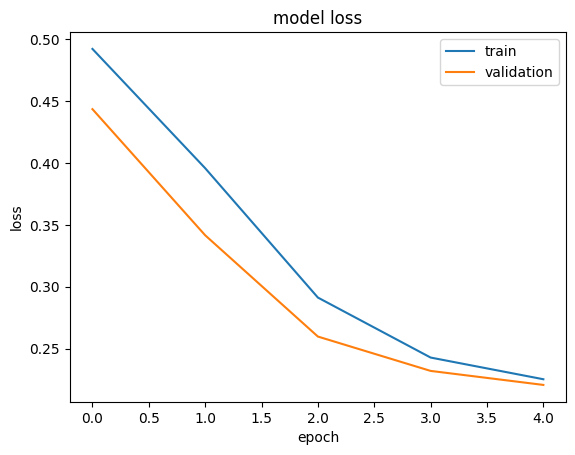

313/313 [==============================] - 2s 5ms/step


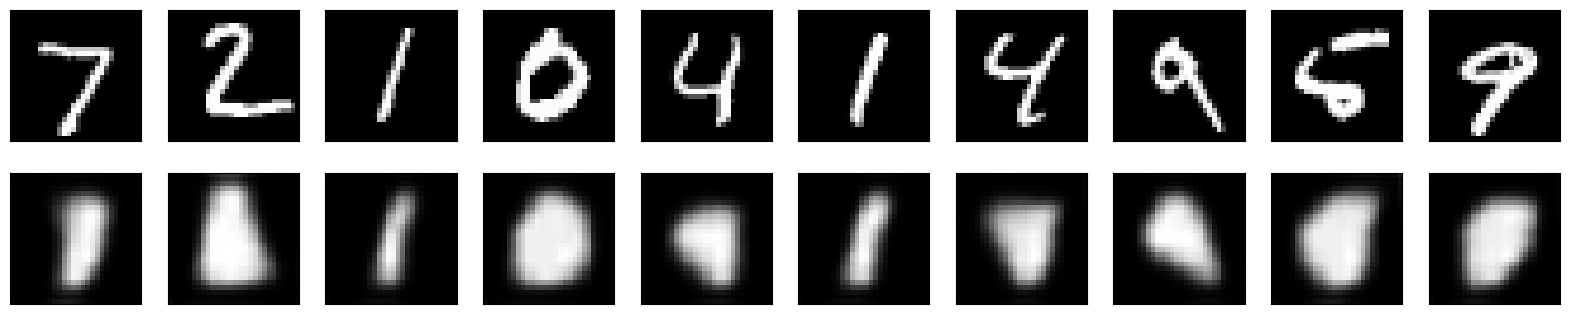

In [6]:
# Create a convolutional autoencoder object
autoencoder = ConvolutionalAutoencoder()

# Train the autoencoder
autoencoder.train_model(X_train, X_test)

#Load pretrained
# autoencoder.load_model("my_model_20230412_153955.h5")

# Plot the loss
autoencoder.plot_loss()

autoencoder.plot_decoded_imgs(X_test)


In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

class Classifier:

    def __init__(self):
        # clf stands for classifier
        self.clf = None

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        print(accuracy_score(y,y_pred))
        return accuracy_score(y, y_pred)

class DecisionTree(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = DecisionTreeClassifier(**kwargs)

class RandomForest(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = RandomForestClassifier(**kwargs)

class XGBoost(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = XGBClassifier(**kwargs)

class NeuralNetwork(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = MLPClassifier(**kwargs)

In [ ]:
# Example usage
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Train a decision tree classifier
dt = DecisionTree()
dt.fit(X, y)
accuracy_dt = dt.score(X, y)

#Since classification is supervised, will try running on the mura_dataset after we obtain the labels

In [ ]:
class Util:
    
    @staticmethod
    def getClusteringClass(user_input_clustering_algorithm, data):
        # create a dictionary that maps user input to the corresponding class
        clustering_class_dict = {
            "kmeans": KMeansClustering(data),
            "dbscan": DBSCANClustering(data),
            "agglomerative": AgglomerativeClusteringAlgorithm(data),
            "meanshift": MeanShiftClustering(data),
            "isolation forest": IsolationForestClustering(data),
            "bgmm": BGMMClustering(data)
        }

        return clustering_class_dict[user_input_clustering_algorithm]
    
class App:
    def __init__(self, filename):
        self.preprocessor = DataPreprocessor(filename)
        self.clustering = None
        
    def start(self):
        
        # Ask the user for preprocessing options
        self.preprocessor.drop_duplicates()
        self.preprocessor.impute_missing()

        # Show the user how the new table looks, and ask the user if he/she wants to download it
        self.preprocessor.display_table()

        data = self.preprocessor.return_data()
        print(data.shape)
        
        # Ask the user for clustering options
        clustering_algorithm = input("""Which clustering algorithm do you wish to use? We currently support the following:
                                        kmeans, dbscan, meanshift, agglomerative, isolation forest, bgmm """)
        
        self.clustering = Util.getClusteringClass(clustering_algorithm, data)

        # Perform clustering
        self.clustering.cluster()
        
        # Measure performance
        silhouette_score = self.clustering.silhouette_score(data)

        # Print the score
        print("Silhouette score:", silhouette_score)


In [ ]:
app = App("mura_data.csv")
app.start()